In [ ]:
!pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.6 MB/s eta 0:00:00


# Model single predict

In [ ]:
model = timm.create_model('ghostnetv2_160.in1k', pretrained=True)
num_outputs = 24
model.classifier = nn.Linear(model.classifier.in_features, num_outputs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/50.1M [00:00<?, ?B/s]

In [ ]:
path_to_state_dict = 'PATH_TO_MODEL'
state_dict = torch.load(path_to_state_dict)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
def predict_random_sample(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    random_idx = torch.randint(low=0, high=images.size(0), size=(1,)).item()

    single_image = images[random_idx].unsqueeze(0).to(device)
    single_label = labels[random_idx]

    # Predict
    with torch.no_grad():
        prediction = model(single_image)
        prediction_tensor = prediction.cpu()

    return prediction_tensor, single_label, single_image

In [ ]:
test_loader = 'HERE INSTERT YOUR LOADER'
prediction, single_label, single_image = predict_random_sample(model, test_loader)

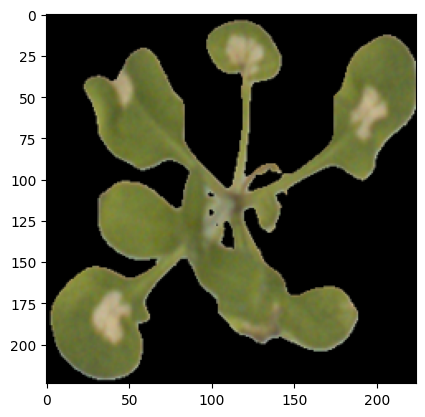

In [ ]:
single_image1 = single_image.cpu().detach().numpy()

if single_image1.shape[0] == 1:
    single_image1 = single_image1.squeeze(0)

if len(single_image1.shape) == 3 and single_image1.shape[0] == 3:
    single_image1 = np.transpose(single_image1, (1, 2, 0))

plt.imshow(single_image1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_image = single_image.to(device)
input_image.requires_grad_()
target_value = torch.ones((1, 24), device=device)

In [ ]:
import cv2

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = []
        self.gradients = []
        self.model.eval()
        self.hooks = []
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.feature_maps.append(output)
        def backward_hook(module, grad_input, grad_output):
            self.gradients.append(grad_output[0])
        self.hooks.append(self.target_layer.register_forward_hook(forward_hook))
        self.hooks.append(self.target_layer.register_backward_hook(backward_hook))

    def generate_cam(self, input_image, target_index):
        output = self.model(input_image)
        self.model.zero_grad()
        target = output[0, target_index]
        target.backward()
        feature_map = self.feature_maps[-1].squeeze().cpu().data.numpy()
        gradients = self.gradients[-1].squeeze().cpu().data.numpy()
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(feature_map.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * feature_map[i, :, :]
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_image.shape[2:])
        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.feature_maps.clear()
        self.gradients.clear()
        self.hooks.clear()

In [ ]:
def visualize_avg_grad_cam_for_layers(model, input_image, start_layer=-10, end_layer=-2,
                                      num_neurons=24, figsize=(15, 15), cmap='jet', alpha=0.5):
    normalized_image = input_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    normalized_image = (normalized_image - normalized_image.min()) / (normalized_image.max() - normalized_image.min())

    num_layers = end_layer - start_layer + 1
    cols = 3
    rows = int(np.ceil(num_layers / cols))

    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.ravel()

    for idx, layer_idx in enumerate(range(start_layer, end_layer + 1)):
        final_conv_layer = model.blocks[layer_idx][-1].ghost1.primary_conv[0]
        grad_cam = GradCAM(model, final_conv_layer)

        cumulative_cam = np.zeros((normalized_image.shape[0], normalized_image.shape[1]))

        for target_index in range(num_neurons):
            cam = grad_cam.generate_cam(input_image, target_index)
            cumulative_cam += cam

        avg_cam = cumulative_cam / num_neurons

        avg_cam = (avg_cam - avg_cam.min()) / (avg_cam.max() - avg_cam.min())

        axs[idx].imshow(normalized_image, cmap='gray')
        axs[idx].imshow(avg_cam, cmap=cmap, alpha=alpha, extent=axs[idx].get_xlim() + axs[idx].get_ylim(), interpolation='bilinear')
        axs[idx].set_title(f'Layer {layer_idx}')
        axs[idx].axis('off')

        grad_cam.remove_hooks()

    for extra in axs[idx+1:]:
        extra.axis('off')

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


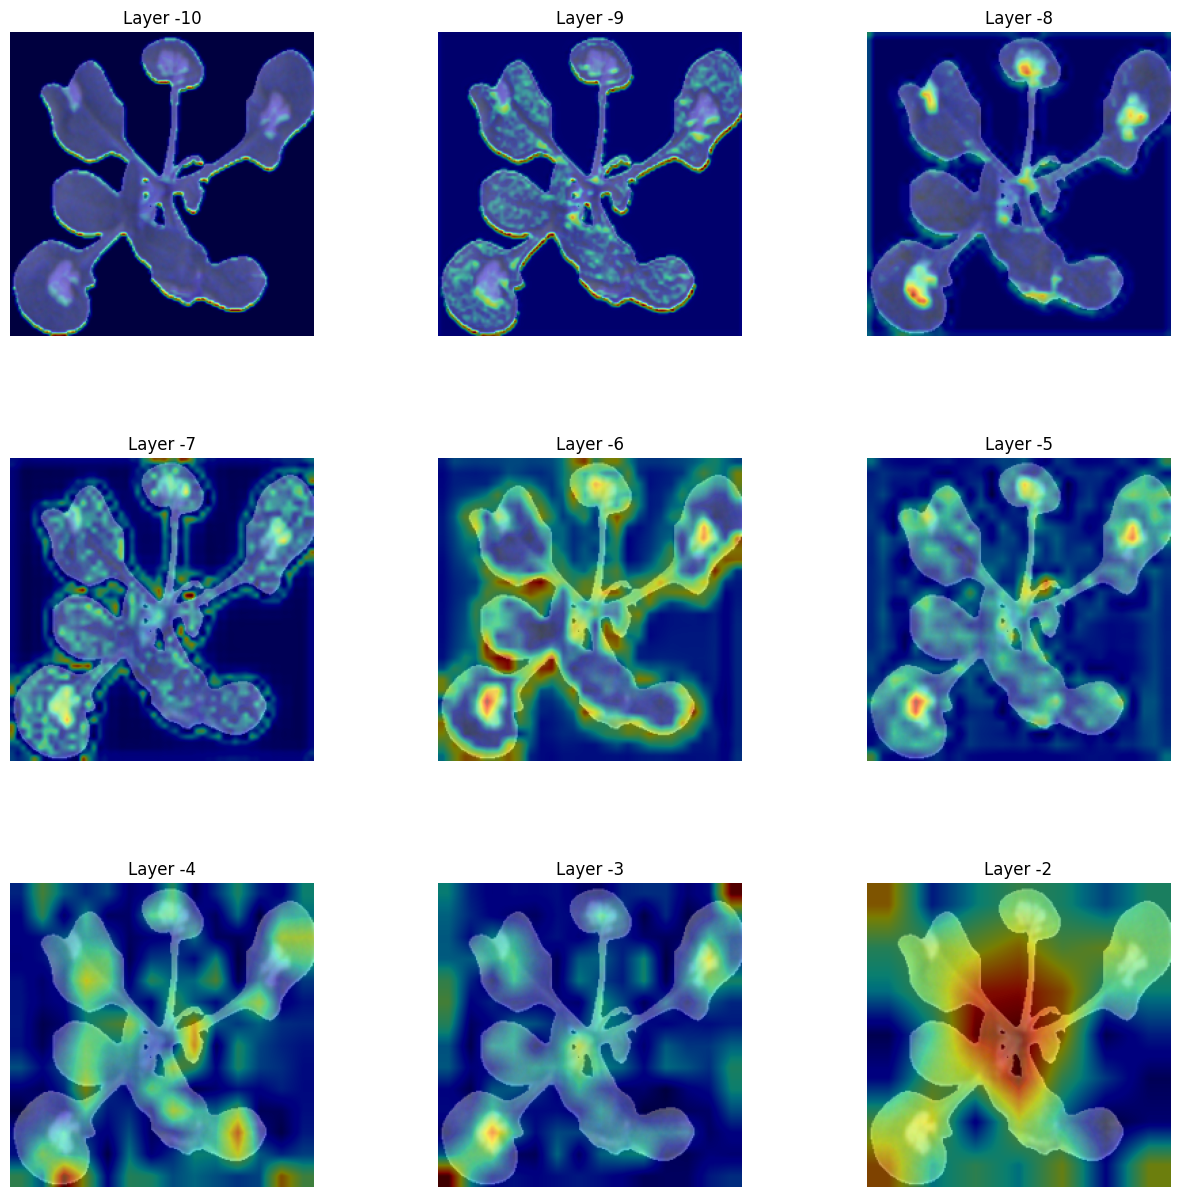

In [ ]:
visualize_avg_grad_cam_for_layers(model, single_image)